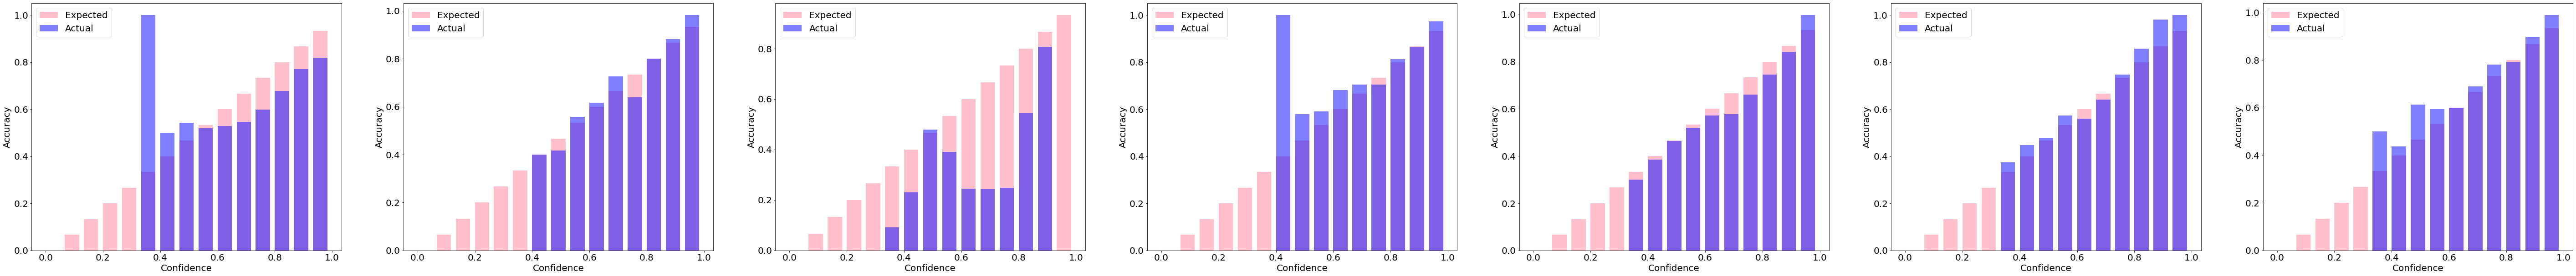

In [6]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
# from calibrate.evaluation.reliability_diagram import ReliabilityDiagram

if __name__ == "__main__":
    

    # dataset_type = "acdc"
    # fname = '223.h5'
    # sno = None   
    
    # dataset_type = "mrbrains"
    # fname = "0.h5" 
    # sno = 24
    
    # dataset_type = "flare"
    # fname = "train_197.h5" 
    # sno = 19
    
    # dataset_type = "brats"
    # fname = "BRATS_456.h5" 
    # sno = 6

    # dataset_type = "refuge"
    # fname = 'T0251.h5'
    # sno = None 

    dataset_type = "promise_mc"
    fname = "prostate_46.h5" 
    sno = 4
    
    params = get_params(dataset_type)
    method_names =['ce','ce_dice','penalty','focal','ls','svls','margin']
    fpath = os.path.join(params.data_root,fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    # diagram = ReliabilityDiagram(bins=25, style="curve")
    
    plt.figure(figsize=(100,10))
    ii = 1
    for key, model_path in zip(method_names,models_path):

        checkpoint = torch.load(model_path)["state_dict"]
        checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
        model.load_state_dict(checkpoint)
        model = model.to('cuda:4')
        
        with h5py.File(fpath, 'r') as data:

            img = data["img"][:]
            mask = data["mask"][:]

        img, mask = pre_process_data(img, mask, dataset_type, sno=sno)

        imgT = torch.from_numpy(img)
        imgT = imgT.unsqueeze(0)
        imgT = imgT.cuda('cuda:4')

        # target = np.expand_dims(mask,axis=0)
        # targetT = torch.from_numpy(target)
        # targetT = targetT.cuda('cuda:4')

        predT = model(imgT.float()).detach().cpu() 
        outputconf = F.softmax(predT,dim=1).numpy()[0]
        output = np.argmax(outputconf,axis=0)
        
        outputconf = np.transpose(outputconf, [1,2,0])
        x, y, c = outputconf.shape
        outputconf = outputconf.reshape(x * y, -1)
        mask = mask.reshape(x * y)
        output = output.reshape(x * y)
        
        outputconf = outputconf[mask>0]
        label = mask[mask>0]
        output = output[mask>0]
        maxconf = np.max(outputconf, axis=1)
        
        # print (outputconf.shape, label.shape, output.shape, maxconf.shape)
        plt.subplot(1,7,ii)
        reliability_plot(maxconf, output, label, key)
                    
        ii = ii + 1
        # bin_strength_plot(maxconf, output, label, key)
        
        # fig_reliab = diagram.plot(outputconf, mask)
        
        # plt.show()